In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import matplotlib.pyplot as plt # this is used for the plot the graph 
import tensorflow_probability as tfp
from tqdm import tnrange, tqdm_notebook
import seaborn as sns
import tensorflow as tf
from scipy import stats
tfd=tfp.distributions
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tqdm import notebook
from sklearn.model_selection import KFold
from scipy.interpolate import interp1d

In [2]:
%matplotlib inline

### Read dt

In [3]:
energydt=np.load('energydt.npy')
x=energydt[:,:-1]
y=energydt[:,-1]


ntrain=865


Code refer to {https://github.com/yaringal/DropoutUncertaintyExps/blob/master/net}

This is the version with homogeneous error

###  MC-Dropout(DP)

In [4]:
class MCdp:
    def __init__(self,tau,dropout):
        self.tau=tau
        self.dropout=dropout

    #use normal approximation for output, by drawing 1000 samples
    def model_musd(self,trainx,trainy,testx):    
        # construct the network
        N = len(trainx)
        batch_size = 128
        lengthscale = 1e-2
        reg = lengthscale**2 * (1 - self.dropout) / (2. * N * self.tau)
        inputs = Input(shape=(trainx.shape[1],))
        inter = Dropout(self.dropout)(inputs, training=True)
        inter = Dense(100, activation='elu',kernel_regularizer=l2(reg))(inputs)
        inter = Dropout(self.dropout)(inter, training=True)
        inter = Dense(80, activation='elu',kernel_regularizer=l2(reg))(inter)
        inter = Dropout(self.dropout)(inter, training=True)
        outputs = Dense(1,kernel_regularizer=l2(reg))(inter)
        model= Model(inputs,outputs)
        opt = keras.optimizers.Adam()
        model.compile(loss='mean_squared_error', optimizer=opt)
        model.fit(trainx, trainy, batch_size=batch_size, epochs=300, verbose=0)

        #generate 1000 posterior samples
        ntest=len(testx)
        Yt_hat=np.zeros((1000,ntest))
        for t in notebook.tnrange(1000):
            mu=model.predict(testx, batch_size=batch_size,verbose=0).ravel() 
            Yt_hat[t,:] = mu
        MC_pred=np.mean(Yt_hat, 0)

        MC_std=np.sqrt(np.diag((Yt_hat.T@Yt_hat)/1000)-MC_pred**2+1./self.tau)
        return MC_pred, MC_std


#### 2-fold cross validation for parameter tuning

In [5]:
tauval=[0.25,0.5,0.75]
dpval=[0.01,0.05,0.1]
hyperparam=np.zeros((9,2))
hyperparam[:,0]=np.repeat(tauval,3)
hyperparam[:,1]=np.tile(dpval,3)

In [7]:
## create 5 folds
id = np.arange(ntrain)
kf = KFold(n_splits=2)
tuneresult=[]


for i in range(len(hyperparam)):
    
    ## tuning parameter
    tautmp=hyperparam[i,0]
    dptmp=hyperparam[i,1]

    for trainid, testid in kf.split(id):
        mcdptmp=MCdp(tautmp,dptmp)
        mutmp,stdtmp=mcdptmp.model_musd(x[trainid],y[trainid],x[testid])

        ## extract validation y
        testytmp=y[testid]
           
        ##likelihood
        low=np.quantile(testytmp,0.05)
        high=np.quantile(testytmp,0.95)
        itv=np.linspace(low,high,9)
        itv=np.append(-np.infty,itv)
        itv=np.append(itv,np.infty)
        #outcome1 belongs to which interval
        ids=np.zeros(len(testytmp))
        for i in range(10):
            ids=ids+1*(testytmp.ravel()>itv[i+1])
        ids=ids.astype('int')
        

        l=(itv[ids]-mutmp)/stdtmp
        r=(itv[ids+1]-mutmp)/stdtmp
        prtmp=stats.norm.cdf(r)-stats.norm.cdf(l)
        ll_est=np.log(prtmp+1.e-10)
        
        tuneresult.append(ll_est.mean())            



In [8]:
list(zip([np.mean(tuneresult[i*2:(i+1)*2]) for i in range(9)],hyperparam))

[(-2.3809167336792343, array([0.25, 0.01])),
 (-2.3812599727394606, array([0.25, 0.05])),
 (-2.3807044452227784, array([0.25, 0.1 ])),
 (-2.1389596753326834, array([0.5 , 0.01])),
 (-2.1331533502664195, array([0.5 , 0.05])),
 (-2.132475062444234, array([0.5, 0.1])),
 (-2.016829578003289, array([0.75, 0.01])),
 (-2.0152173059648715, array([0.75, 0.05])),
 (-2.0102002433633817, array([0.75, 0.1 ]))]

### Ten replications to evaluate the hard metrics

In [9]:
##function to create replication
def rep_iter(x,y,frac=0.4):
    n=len(x)
    ntest=int(np.floor(frac*n))
    allidx=np.random.permutation(n)
    trainidx= allidx[ntest:]
    testidx= allidx[:ntest]
    return x[trainidx],y[trainidx],x[testidx],y[testidx]
    

In [10]:
#initialize the metric
dpll=[]
dpcal=[]
dpcalshp=[] #empirical coverage
dpwidth=[] #empirical width
dp90=[] #90 interval coverage
dpmae=[]

dpcrll=[]
dpcrcal=[]
dpcrcalshp=[] #empirical coverage
dpcrwidth=[] #empirical width
dpcr90=[] #90 interval coverage
dpcrmae=[]



In [11]:
np.random.seed(2021)
for a in range(10):
    train_x,train_y,test_x,test_y=rep_iter(x,y)
    
    #train recalibration
    ntr=len(train_x)
    nval=int(np.floor(ntr*0.4))

    mcdptuned=MCdp(0.75,0.1)
    mucal,stdcal=mcdptuned.model_musd(train_x[nval:],train_y[nval:],train_x[:nval])
    
    
    #recalibration
    
    #option 1 in doing calibration, when sample size is sufficient enough
    ## proposed value are our nominal belif
#     proposep=np.linspace(0.001,0.999,100)
#     truep=np.zeros_like(proposep)
#     for i in range(100):
#         outtmp=stats.norm.ppf(proposep[i])*stdcal+mucal
#         truep[i]=(train_y[:nval].ravel()<outtmp.ravel()).mean()
#     truep=np.append(0,truep)
#     truep=np.append(truep,1)

#     proposep=np.append(0,proposep)
#     proposep=np.append(proposep,1)

    #calibration option 2, use realized qunatiles  
    proposep=np.sort(stats.norm.cdf((train_y[:nval].ravel()-mucal)/stdcal))
    proposep=np.append(0,proposep)
    proposep=np.append(proposep,1)
    truep=np.linspace(0,1,nval+2)
    
    
    cr= interp1d(truep, proposep)
    crinv= interp1d(proposep, truep)

    #formal training
    mcdptuned=MCdp(0.75,0.01)
    dpmu,dpstd=mcdptuned.model_musd(train_x,train_y,test_x)
    
    #####calculate metrics##############

    per=np.linspace(0.02,0.98,8) #quantile to study calibration
    #pershp=np.linspace(0.4,0.999,20) #nominal quantile to study sharpness
    pershp=np.linspace(0.03,0.999,50) #nominal quantile to study sharpness, incert more points, since this case over estimate variance



    dpc=[]
    dpcrc=[]
    for i in per:
        lquantile=(stats.norm.ppf(0.5-i/2.)*dpstd+dpmu)
        rquantile=(stats.norm.ppf(0.5+i/2.)*dpstd+dpmu)
        dpc.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))

        lquantilecr=(stats.norm.ppf(cr(0.5-i/2.))*dpstd+dpmu)
        rquantilecr=(stats.norm.ppf(cr(0.5+i/2.))*dpstd+dpmu)
        dpcrc.append(np.mean((test_y.ravel()<rquantilecr.ravel())*(test_y.ravel()>lquantilecr.ravel())))

    dpcal.append(dpc)
    dpcrcal.append(dpcrc)
    
    
    #sharpness
    dpc1=[]    
    dpwid=[]
    dpcrc1=[]    
    dpcrwid=[]
    for i in pershp:
        lquantile=(stats.norm.ppf(0.5-i/2.)*dpstd+dpmu)
        rquantile=(stats.norm.ppf(0.5+i/2.)*dpstd+dpmu)
        dpc1.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))
        dpwid.append(np.median(rquantile-lquantile))
        
        lquantilecr=(stats.norm.ppf(cr(0.5-i/2.))*dpstd+dpmu)
        rquantilecr=(stats.norm.ppf(cr(0.5+i/2.))*dpstd+dpmu)
        dpcrc1.append(np.mean((test_y.ravel()<rquantilecr.ravel())*(test_y.ravel()>lquantilecr.ravel())))
        dpcrwid.append(np.median(rquantilecr-lquantilecr))
        
    dpcalshp.append(np.array(dpc1))    
    dpwidth.append(np.array(dpwid))
    
    dpcrcalshp.append(np.array(dpcrc1))    
    dpcrwidth.append(np.array(dpcrwid))
    
    
    #ninty
    l90=(stats.norm.ppf(0.5-0.9/2.)*dpstd+dpmu)
    r90=(stats.norm.ppf(0.5+0.9/2.)*dpstd+dpmu)
    dp90.append(np.mean((test_y.ravel()<r90.ravel())*(test_y.ravel()>l90.ravel())))
    
    #ninty
    l90cr=(stats.norm.ppf(cr(0.5-0.9/2.))*dpstd+dpmu)
    r90cr=(stats.norm.ppf(cr(0.5+0.9/2.))*dpstd+dpmu)
    dpcr90.append(np.mean((test_y.ravel()<r90cr.ravel())*(test_y.ravel()>l90cr.ravel())))
    
    #log likelihood
    low=np.quantile(test_y,0.05)
    high=np.quantile(test_y,0.95)
    itv=np.linspace(low,high,9)
    itv=np.append(-np.infty,itv)
    itv=np.append(itv,np.infty)
    #outcome1 belongs to which interval
    id=np.zeros(len(test_y))
    for i in range(10):
        id=id+1*(test_y.ravel()>itv[i+1])
    id=id.astype('int')

    l=(itv[id]-dpmu)/dpstd
    r=(itv[id+1]-dpmu)/dpstd
    prtmp=stats.norm.cdf(r)-stats.norm.cdf(l)
    ll_est=np.log(prtmp+1e-10)
    dpll.append(ll_est.mean())
    
    prtmpcr=crinv(stats.norm.cdf(r))-crinv(stats.norm.cdf(l))

    ll_estcr=np.log(prtmpcr+1e-10)
    dpcrll.append(ll_estcr.mean())
    
    #mae
    dpmae.append(np.abs(dpmu-test_y.ravel()).mean()) 
    dpcrmae.append(np.abs(dpmu+stats.norm.ppf(cr(0.5))*dpstd-test_y.ravel()).mean())
    

In [12]:
def musd(x):
    print(np.mean(x),np.std(x))

musd(dpll)
musd(dp90)
musd(dpmae)

musd(dpcrll)
musd(dpcr90)
musd(dpcrmae)


-2.0086785447122746 0.031887886277118534
0.9755208333333332 0.005404299450094936
0.5534385955422082 0.015226199368666482
-1.8589352173254423 0.021553041939248428
0.8895833333333334 0.02367994459948265
0.5538061195776631 0.015442989402874788


In [14]:
#calibration
def calcompu(x):
    x=np.array(x)
    n=len(x)
    cal=np.mean(x,0)
    calest=np.abs(x-per).mean(1)
    
    print(np.mean(calest),np.std(calest))
    
    return  cal

dpcalplot=calcompu(dpcal)
dpcrcalplot=calcompu(dpcrcal)

0.1536241319444444 0.005674363371628008
0.024492931547619057 0.0075824448588786685


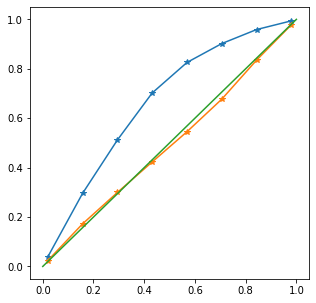

In [15]:
## calibration plot
plt.figure(figsize=(5,5))
plt.plot(per,dpcalplot,'-*')
plt.plot(per,dpcrcalplot,'-*')



plt.plot([0,1],[0,1])

In [23]:
dpcalplot

array([0.0390625 , 0.29600694, 0.51180556, 0.70208333, 0.82552083,
       0.90190972, 0.95868056, 0.99392361])

In [24]:
dpcrcalplot

array([0.02395833, 0.17256944, 0.29947917, 0.42291667, 0.54513889,
       0.67690972, 0.83472222, 0.97795139])

In [25]:
def shpplt(cal,width): #median interval width calculation
    n=len(cal)
    cal=np.array(cal)
    width=np.array(width)
    low=np.max(cal[:,0])
    up=np.min(cal[:,-1])
    rangeint=np.linspace(low,up,30)
    widest=[]
    for i in range(n):
        widest.append(interp1d(cal[i],width[i])(rangeint))
    
    return rangeint,np.array(widest).mean(0)


In [26]:
dpempcal,dpempwid=shpplt(dpcalshp,dpwidth)
dpcrempcal,dpcrempwid=shpplt(dpcrcalshp,dpcrwidth)

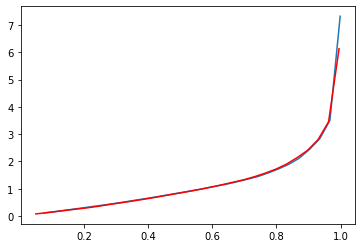

In [27]:
plt.plot(dpempcal,dpempwid)
plt.plot(dpcrempcal,dpcrempwid,color='red')